# **Modelling**

## **Step1.** Import Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
#flights table
data = pd.read_csv('/Users/Prashanta/Desktop/airplane_data/flights_table(50,000_points).csv',delimiter=';')
data = data.iloc[: , 1:]

#create two samples of 10,000 points each
sample1 = data.sample(n=10000, random_state=0)
sample2 = data.sample(n=10000, random_state=1)

#Adding date time features and state
sample1['month'] = pd.DatetimeIndex(sample1['fl_date']).month
sample2['month'] = pd.DatetimeIndex(sample2['fl_date']).month
sample1['year'] = pd.DatetimeIndex(sample1['fl_date']).year
sample2['year'] = pd.DatetimeIndex(sample2['fl_date']).year
sample1['origin_city_state'] = sample1['origin_city_name'].transform(lambda x: str(x).split(',')[1])
sample2['origin_city_state'] = sample2['origin_city_name'].transform(lambda x: str(x).split(',')[1])
sample1['depart_hour'] = sample1['dep_time'].round(-2)
sample2['depart_hour'] = sample2['dep_time'].round(-2)

In [4]:
display(data.head(3))
display(data.shape)

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name
0,2019-12-30,WN,WN,WN,775,WN,N255WN,775,13495,MSY,...,674.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-04-08,AS,AS,AS,352,AS,N464AS,352,14747,SEA,...,672.0,0.0,0.0,25.0,0.0,0.0,NaN,NaN,NaN,NaN
2,2018-11-21,DL,DL,DL,1312,DL,N912DL,1312,10994,CHS,...,259.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(50000, 42)

## **Step2.** Create BaseModel using Linear Regression

In [135]:
#create test model df
test_model_1 = sample1[['month','origin_city_state','depart_hour','arr_delay']]

# Droping nan value rows
test_model_1.dropna(inplace=True)

# Encode Cateogircal Values 
# Change dtype of variable to category then encode using cat.codes
test_model_1['origin_city_state'] = test_model_1['origin_city_state'].astype('category')
test_model_1['origin_city_state'] = test_model_1['origin_city_state'].cat.codes

#Assign train and target variables
X = test_model_1[['month','origin_city_state','depart_hour']]
y = test_model_1['arr_delay']

<ipython-input-135-ac5d82c39b9a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_model_1.dropna(inplace=True)
<ipython-input-135-ac5d82c39b9a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_model_1['origin_city_state'] = test_model_1['origin_city_state'].astype('category')
<ipython-input-135-ac5d82c39b9a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

In [136]:
# split X and y into training and testing sets 
import sklearn.model_selection as model_selection

X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,train_size=0.75,test_size=0.25,random_state=123)

# import libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

#initialize and fit training dataset
Linear_Regressor = LinearRegression()
Linear_Regressor.fit(X_train, y_train)

#make prediction 
y_pred = Linear_Regressor.predict(X_test)

#prints the coefficients used for each attribute
print('variables', list(X.columns))
print('coefficients:', Linear_Regressor.coef_)
print()

#prints the R2 score for your test dataset
print('R2 Score for train data:', round(Linear_Regressor.score(X_train,y_train),3))
print('R2 Score2 for test data:', round(r2_score(y_test,y_pred),3))
print('MAE Score for test data: ', round(mean_absolute_error(y_test,y_pred),2))

variables ['month', 'origin_city_state', 'depart_hour']
coefficients: [-0.07959701  0.04777177  0.01045926]

R2 Score for train data: 0.012
R2 Score2 for test data: 0.015
MAE Score for test data:  23.62


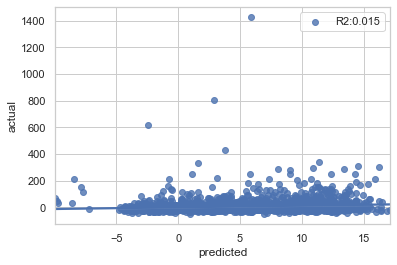

In [137]:
df = pd.DataFrame(
        {
            'actual':y_test,
            'predicted':y_pred
        }
)
df

sns.regplot(x='predicted',y='actual',data=df,label='R2:'+ str(round(r2_score(y_test,y_pred),3)))
plt.legend(loc=0)

## **Step3.** Add key features to basemodel and run Linear Reg again

In [124]:
#Feature1 - Average_dep_delay per airport
#create a dummy column and then replace values with average dep_delay per state
sample1['dep_delay_state'] = sample1['dep_delay']
sample1['dep_delay_state'] = sample1[['dep_delay_state','origin_city_state']].groupby(by='origin_city_state').transform(lambda x: x.mean())

#Feature2 - Average_arr_delay per airport
#create a dummy column and then replace values with average arr_delay per state
sample1['arr_delay_state'] = sample1['arr_delay']
sample1['arr_delay_state'] = sample1[['arr_delay_state','origin_city_state']].groupby(by='origin_city_state').transform(lambda x: x.mean())

In [125]:
#create test model df
test_model_2 = sample1[['month','origin_city_state','depart_hour','dep_delay_state','arr_delay_state','arr_delay']]

# Droping nan value rows
test_model_2.dropna(inplace=True)

# Encode Cateogircal Values 
# Change dtype of variable to category then encode using cat.codes
test_model_2['origin_city_state'] = test_model_2['origin_city_state'].astype('category')
test_model_2['origin_city_state'] = test_model_2['origin_city_state'].cat.codes

#Assign train and target variablesa
X = test_model_2[['month','origin_city_state','depart_hour','dep_delay_state','arr_delay_state']]
y = test_model_2['arr_delay']

<ipython-input-125-bd7314cd9e29>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_model_2.dropna(inplace=True)
<ipython-input-125-bd7314cd9e29>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_model_2['origin_city_state'] = test_model_2['origin_city_state'].astype('category')
<ipython-input-125-bd7314cd9e29>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

In [126]:
# split X and y into training and testing sets 
import sklearn.model_selection as model_selection

X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,train_size=0.75,test_size=0.25,random_state=123)

# import libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

#initialize and fit training dataset
Linear_Regressor = LinearRegression()
Linear_Regressor.fit(X_train, y_train)

#make prediction 
y_pred = Linear_Regressor.predict(X_test)

#prints the coefficients used for each attribute
print('variables', list(X.columns))
print('coefficients:', Linear_Regressor.coef_)
print()

#prints the R2 score for your test dataset
print('R2 Score for train data:', round(Linear_Regressor.score(X_train,y_train),3))
print('R2 Score for test data:', round(r2_score(y_test,y_pred),3))
print('MAE Score for test data:', round(mean_absolute_error(y_test,y_pred),2))

variables ['month', 'origin_city_state', 'depart_hour', 'dep_delay_state', 'arr_delay_state']
coefficients: [-0.07355369  0.04175744  0.01041261  0.14653548  1.05282136]

R2 Score for train data: 0.024
R2 Score for test data: 0.012
MAE Score for test data: 23.83


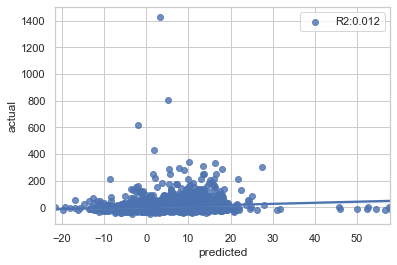

In [133]:
df = pd.DataFrame(
        {
            'actual':y_test,
            'predicted':y_pred
        }
)
df

sns.regplot(x='predicted',y='actual',data=df,label='R2:'+ str(round(r2_score(y_test,y_pred),3)))
plt.legend(loc=0)

## **Step4.** Remove outlier data from Key Features

In [138]:
# create no_outlier data by using 1.5*Q1 and 1.5*Q3 as outlier boundaries
filter1 = (sample1['arr_delay'] < 10.5) & (sample1['arr_delay'] > -22.5)
sample1_no_outliers = sample1[filter1]
#(sample1_no_outliers[['origin_city_state','dep_delay','arr_delay']].groupby(by='origin_city_state').mean().reset_index()).sort_values('arr_delay',ascending=False).head(10)

In [139]:
#Feature1 - Average_dep_delay per airport
#create a dummy column and then replace values with average dep_delay per state
sample1_no_outliers['dep_delay_state'] = sample1_no_outliers['dep_delay']
sample1_no_outliers['dep_delay_state'] = sample1_no_outliers[['dep_delay_state','origin_city_state']].groupby(by='origin_city_state').transform(lambda x: x.mean())

#Feature2 - Average_arr_delay per airport
#create a dummy column and then replace values with average arr_delay per state
sample1_no_outliers['arr_delay_state'] = sample1_no_outliers['arr_delay']
sample1_no_outliers['arr_delay_state'] = sample1_no_outliers[['arr_delay_state','origin_city_state']].groupby(by='origin_city_state').transform(lambda x: x.mean())

#create test model df
test_model_3 = sample1[['month','origin_city_state','depart_hour','dep_delay_state','arr_delay_state','arr_delay']]

# Droping nan value rows
test_model_3.dropna(inplace=True)

# Encode Cateogircal Values 
# Change dtype of variable to category then encode using cat.codes
test_model_3['origin_city_state'] = test_model_3['origin_city_state'].astype('category')
test_model_3['origin_city_state'] = test_model_3['origin_city_state'].cat.codes

#Assign train and target variablesa
X = test_model_3[['dep_delay_state','arr_delay_state']]
y = test_model_3['arr_delay']

<ipython-input-139-eb1c48cb5171>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample1_no_outliers['dep_delay_state'] = sample1_no_outliers['dep_delay']
<ipython-input-139-eb1c48cb5171>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample1_no_outliers['dep_delay_state'] = sample1_no_outliers[['dep_delay_state','origin_city_state']].groupby(by='origin_city_state').transform(lambda x: x.mean())
<ipython-input-139-eb1c48cb5171>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [140]:
# split X and y into training and testing sets 
import sklearn.model_selection as model_selection

X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,train_size=0.75,test_size=0.25,random_state=123)

# import libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

#initialize and fit training dataset
Linear_Regressor = LinearRegression()
Linear_Regressor.fit(X_train, y_train)

#make prediction 
y_pred = Linear_Regressor.predict(X_test)

#prints the coefficients used for each attribute
print('variables', list(X.columns))
print('coefficients:', Linear_Regressor.coef_)
print()

#prints the R2 score for your test dataset
print('R2 Score for train data:', round(Linear_Regressor.score(X_train,y_train),3))
print('R2 Score for test data:', round(r2_score(y_test,y_pred),3))
print('MAE Score for test data:', round(mean_absolute_error(y_test,y_pred),2))

variables ['dep_delay_state', 'arr_delay_state']
coefficients: [0.02614111 1.17016504]

R2 Score for train data: 0.012
R2 Score for test data: -0.003
MAE Score for test data: 24.19


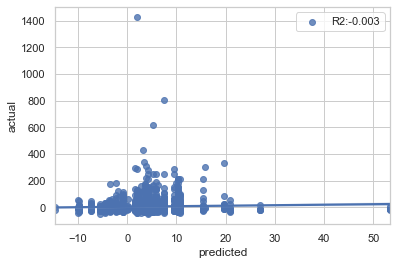

In [141]:
df = pd.DataFrame(
        {
            'actual':y_test,
            'predicted':y_pred
        }
)
df

sns.regplot(x='predicted',y='actual',data=df,label='R2:'+ str(round(r2_score(y_test,y_pred),3)))
plt.legend(loc=0)